# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

___
##### The goal is to develop a predictive model to analyze and determine the most significant factors influencing used car prices. 
This involves collecting and preparing relevant datasets, conducting exploratory data analysis to identify potential features, and employing statistical and machine learning techniques to quantify the impact of these features on pricing. Key metrics for model performance will be evaluated to ensure accuracy and reliability in predicting used car prices

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Exploratory Data Analysis

1. Read CSV
2. Understand data structure and independent variables
3. Determine missing values and explore the right strategy for treating them (drop columns or rows, and filling missing values - mode, mean or use KNN)
4. Understand categorical variables
 

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import root_mean_squared_error

import time


In [298]:
# read vehicles data

vehicles = pd.read_csv('data/vehicles.csv')

print("Number of rows and columns in the dataset:", vehicles.shape)


Number of rows and columns in the dataset: (426880, 18)


In [299]:
# review the columns in the data set 

vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [300]:
# check the summary statistics of the numerical values

vehicles.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


--- 
* The price, odometer and year columns have a wide range of data. May require outlier treatment

In [301]:
# unique values per column

vehicles.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

In [302]:

# Count missing %s
vehicles.isna().mean().round(4)*100


id               0.00
region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
VIN             37.73
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64

In [303]:
#Descriptive statistics for categorical variables
vehicles.describe(include=['object', 'category'])

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,50614


--- 
* Categorical variables: The columns `region`, `manufacturer`, `model`, and `state` have a large number of unique values, requiring an appropriate strategy for treatment.
* VIN numbers: There are only 265K unique VIN numbers in a dataset of 426K observations, indicating possible duplicate entries.
* Missing values: The columns `condition`, `cylinders`, `VIN`, `drive`, `size`, `type`, and `paint_color` have more than 25% missing values.
* Outliers: The columns `price`, `odometer`, and `year` have a wide range of data, which may require outlier treatment.


## Data Quality / Clean up

After an initial review of data, the following data quality and clean up steps need to be addressed:

1. Remove irrelevant data: IDs, VINs
2. Remove categorical columns with a large number of unique values (region, model, state) - These can be added back after the first pass of model creation if needed
3. Remove columns with more than 50% missing data (size)
4. Drop duplicate rows
5. Convert data types:
    - Extract the number of cylinders as a numerical value
6. Perform outlier analysis and removal for the price, odometer, and year columns



In [304]:
# remove object columns that we intuitively know to be not related to the price of a used car such as id, VIN
vehicles_clean = vehicles.drop(columns = ['id', 'VIN'])

# remove categorical variables with very large unique values - region(404), model(29649), state(51). This may be reintroduced later 
# if do not find any other variables that can help build a good model
vehicles_clean = vehicles_clean.drop(columns = ['region', 'model', 'state'])

# remove columns with > 50% missing values
vehicles_clean = vehicles_clean.drop(columns = ['size'])

# drop duplicates
vehicles_clean = vehicles_clean.drop_duplicates()

vehicles_clean.shape

(244870, 12)

In [305]:

# convert cylinders to numeric values

vehicles_clean['cylinders'] = vehicles_clean['cylinders'].str.replace('cylinders', '', regex=False)

vehicles_clean['cylinders_numeric'] = pd.to_numeric(vehicles_clean['cylinders'], errors='coerce', downcast='integer')
print(vehicles_clean['cylinders_numeric'].value_counts())

vehicles_clean.drop(columns = 'cylinders', inplace=True)

# dropping all the rows will null values, drops about 90% of the data. This is not ideal. However this does imove the r2 scores
# this code has been commented out, and was used to run the whole program for evaluation purposes only
# 
# vehicles_clean.dropna(inplace=True)


cylinders_numeric
4.0     56018
6.0     55892
8.0     41499
5.0      1355
10.0      717
3.0       449
12.0      153
Name: count, dtype: int64


In [306]:
# Address outliers in price and odometer columns by keeping values betweeen a function of 10th and 90th percentile

def address_outlier_iqr(df, column):
    iqr = df[column].quantile(.9) - df[column].quantile(.1)
    lower_bound = df[column].quantile(.1) - 1.5 * iqr
    upper_bound = df[column].quantile(.9) + 1.5 * iqr

    df_without_outliers = df[(df[column] > lower_bound) & (df[column] < upper_bound)].copy()
    iqr_data_lost = 1-(df_without_outliers.shape[0]/df.shape[0])
    print("We lost {:.2%} of the data by the IQR method".format(iqr_data_lost), "for the", column, "column")
    
    return df_without_outliers

vehicles_clean = address_outlier_iqr(vehicles_clean, 'price')
vehicles_clean = address_outlier_iqr(vehicles_clean, 'odometer')

vehicles_clean.select_dtypes(include=['float64', 'int64']).describe()


We lost 0.45% of the data by the IQR method for the price column
We lost 1.48% of the data by the IQR method for the odometer column


,price,year,odometer,cylinders_numeric
count,240175.000000,239562.000000,240175.000000,154037.000000
mean,14011.897142,2009.425422,103244.369385,5.810578
std,12854.170825,10.628936,64096.450892,1.611399
min,0.000000,1900.000000,0.000000,3.000000
25%,4950.000000,2006.000000,52396.000000,4.000000
50%,9999.000000,2012.000000,99761.000000,6.000000
75%,19748.000000,2016.000000,145000.000000,8.000000
max,78609.000000,2022.000000,440000.000000,12.000000


In [307]:
# check the percentages of missing values after initial clean up

vehicles_clean.isna().mean().round(4)*100

price                 0.00
year                  0.26
manufacturer          4.12
condition            39.40
fuel                  0.56
odometer              0.00
title_status          1.60
transmission          0.39
drive                28.23
type                 25.01
paint_color          29.66
cylinders_numeric    35.86
dtype: float64

## Exploratory Data Analysis (EDA)

* Univariate

* Bi-variate (price as the main focus)
    For ex: how cylinders and prices move together


#### EDA for Numerical Variables

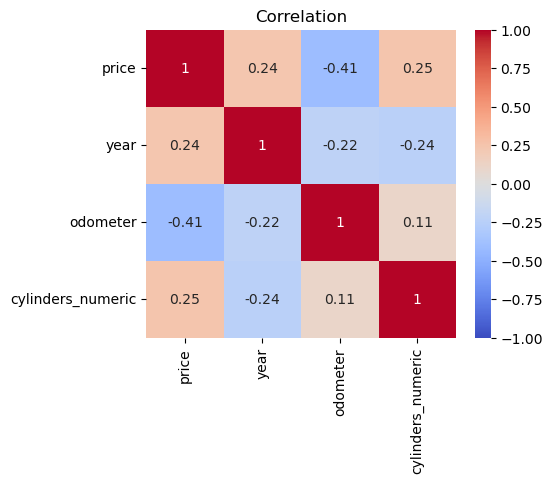

In [308]:
# Create a correlation heatmap using numerical features

plt.figure(figsize=(5, 4))
sns.heatmap(vehicles_clean.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation')
plt.show()

### Correlation Plot Analysis

- **Price and Odometer**: There is a moderate negative correlation between price and odometer reading (-0.41). This indicates that as the odometer reading increases, the price of the car tends to decrease. This is expected as cars with higher mileage are generally less expensive.

- **Price and Cylinders**: There is a positive correlation between price and the number of cylinders (0.25). This suggests that cars with more cylinders tend to be priced higher. This could be due to the fact that cars with more cylinders are used for special purposes, and perhaps even be considered premium

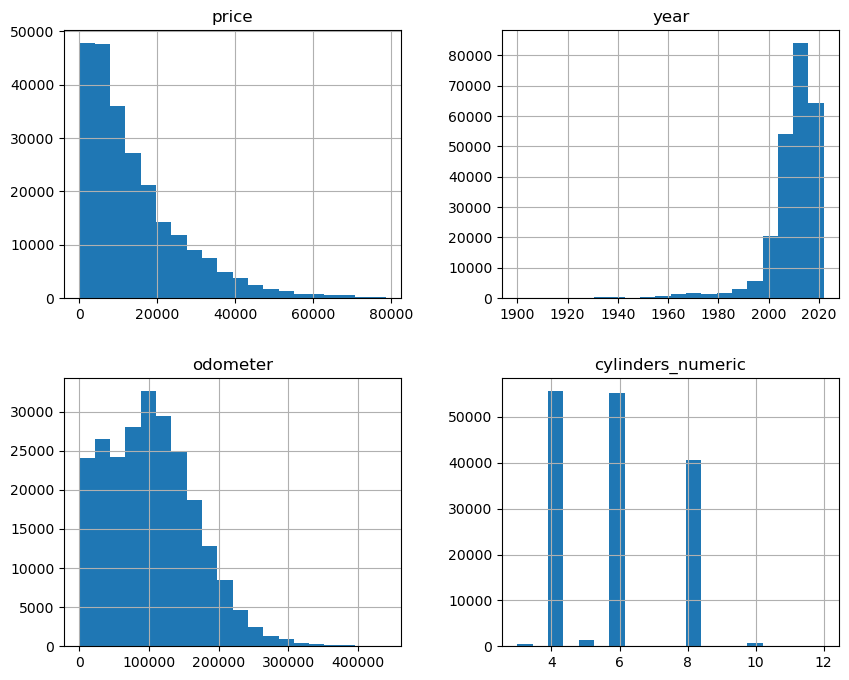

In [309]:
# Histogram/Barplots for numerical variables

vehicles_clean.hist(bins=20, figsize=(10, 8))
plt.show()

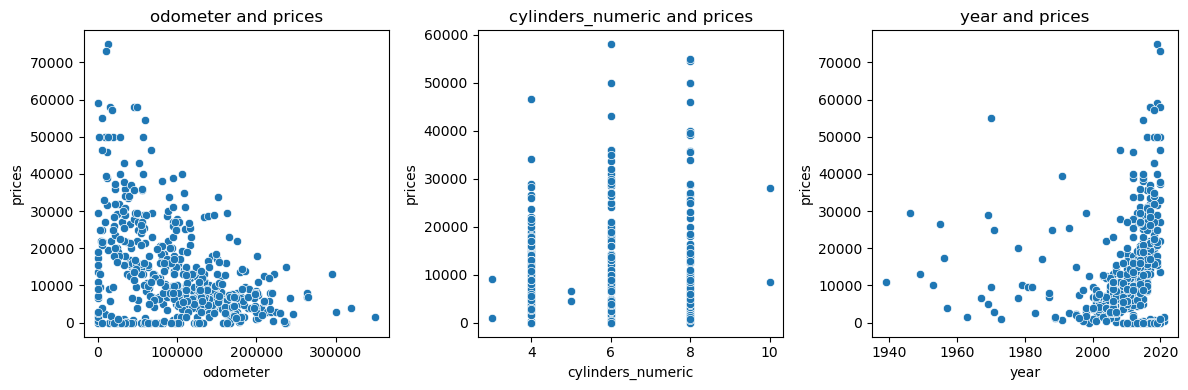

In [310]:
# Pick a random sample for displaying and diserning any patterns in scatter plots

np.random.seed(42)
df_numeric_sample = vehicles_clean.sample(500)

# Numerical variables
numerical_columns = ['odometer', 'cylinders_numeric', 'year']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, column in enumerate(numerical_columns):
    sns.scatterplot(x=df_numeric_sample[column], y=df_numeric_sample['price'], ax=axes[i])
    axes[i].set_title(f'{column} and prices')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('prices')

plt.tight_layout()
plt.show()

* It appears that as age and odometer of the car increases the price goes down
* Cars with 6-8 cylinders appear to get more price
* As expected newer model vehicles command a higher value. There are exceptions with older year vehicles that require further investigation.

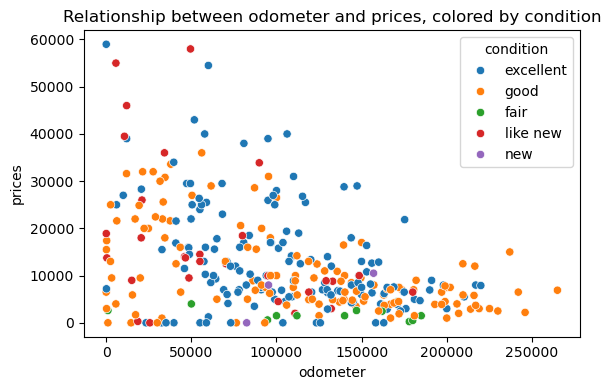

In [311]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_numeric_sample['odometer'], y=df_numeric_sample['price'], hue=df_numeric_sample['condition'])

plt.title('Relationship between odometer and prices, colored by condition')
plt.xlabel('odometer')
plt.ylabel('prices')

plt.tight_layout()
plt.show()

--- 
* Odometer and prices show an inverse relationship: vehicles with in excellent condition appear to be valued more than other conditions

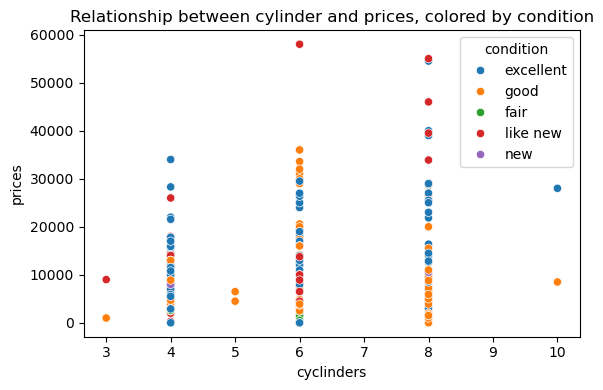

In [312]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_numeric_sample['cylinders_numeric'], y=df_numeric_sample['price'], hue=df_numeric_sample['condition'])

plt.title('Relationship between cylinder and prices, colored by condition')
plt.xlabel('cyclinders')
plt.ylabel('prices')

plt.tight_layout()
plt.show()

--- 
* number of cylinders and prices show an positive relationship: vehicles with more
         number of cylinders are valued more, assuming the condition is like new

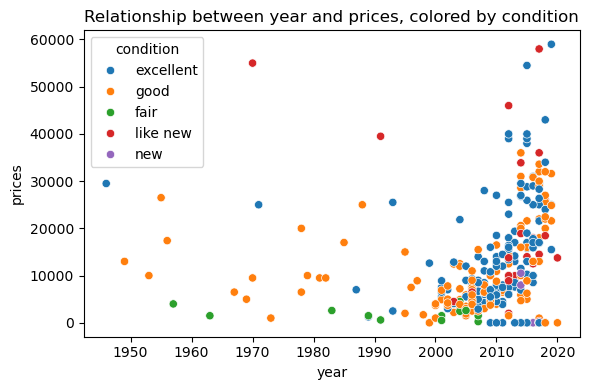

In [313]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_numeric_sample['year'], y=df_numeric_sample['price'], hue=df_numeric_sample['condition'])

plt.title('Relationship between year and prices, colored by condition')
plt.xlabel('year')
plt.ylabel('prices')

plt.tight_layout()
plt.show()

--- 
* Years and prices: newer vehicles appear to command higher prices : There are situations such as a like new car that is year 1970 at the top of the chart. This may be an error in the data set or the car never have been driven

In [314]:
#sns.pairplot(df_numeric_sample , hue='condition' )

##### Interpretation

* Customers value vehicles with higher number of cylinders (4,6,8)
* Customers do not appear to value vehicles that are older, and has lots of mileage on the odometers

#### EDA for Categorical Variables

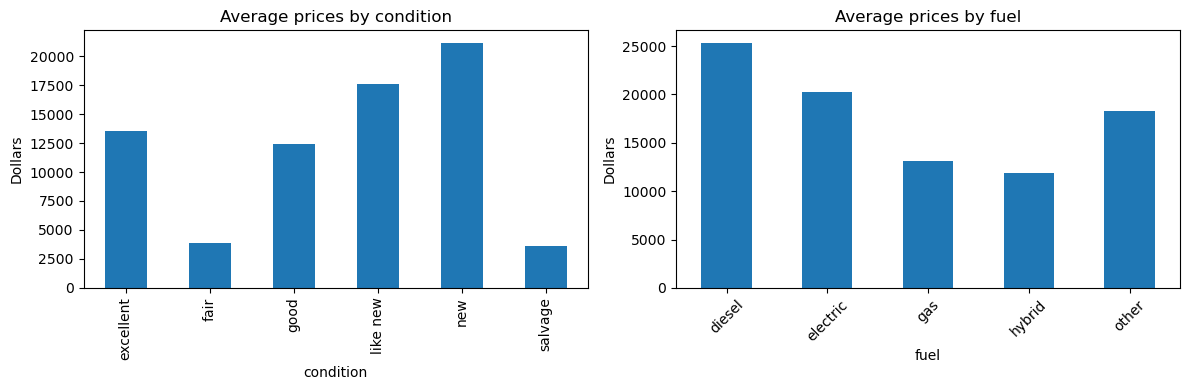

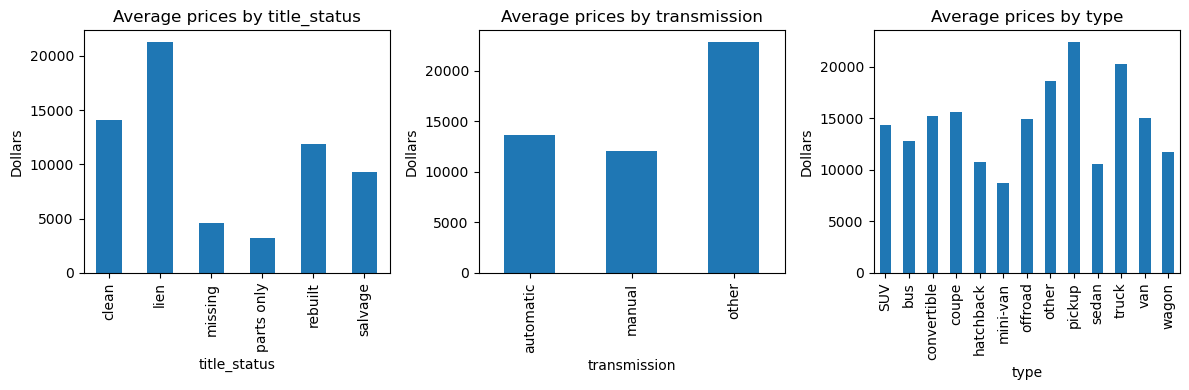

In [315]:
# Let's explore the price with categorical variables

categorical_columns = ['condition',  'fuel']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, column in enumerate(categorical_columns):
    mean_costs = vehicles_clean.groupby(column)['price'].mean()
    mean_costs.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average prices by {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Dollars')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

categorical_columns = ['title_status', 'transmission', 'type']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, column in enumerate(categorical_columns):
    mean_costs = vehicles_clean.groupby(column)['price'].mean()
    mean_costs.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average prices by {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Dollars')

plt.tight_layout()
plt.show()



---
* Vehicles with condition `(New/Like New)` tend to be priced higher. On the other hands cars with `salvaged` condition tend to be priced the lowest
* `Pickups` tend to attract higher prices, mini-vans on the other hand appear to sell for less
* `Diesel` vehicles tend to attract higher prices
* Vehicles with more `cyclinders` are more expensive


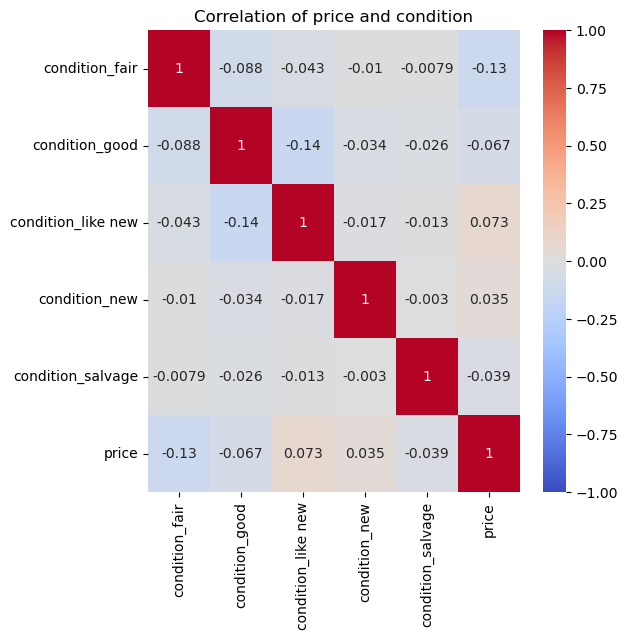

In [316]:
# check the correlation between the categorical variables and price
# 
df = pd.get_dummies(vehicles_clean, 
                    columns=['condition', 'fuel', 'title_status', 'transmission', 'type'], 
                    drop_first=True,dtype='int64')

df.drop(columns = ['drive', 'paint_color', 'manufacturer'], inplace=True)

import re
pattern = re.compile(r'condition')
selected_columns = pd.Series([col for col in df.columns if pattern.search(col)])
selected_columns = pd.concat([selected_columns, pd.Series(['price'])])

filtered_df = df[selected_columns].dropna()

plt.figure(figsize=(6, 6))
sns.heatmap(filtered_df.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of price and condition')
plt.show()


---
* Vehicles with condition `Like New` appear to have a slight postive corelation with price

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Pre-processing

1. Split the data into train/test sets, before imputing any of the missing values
2. Standardize and scale the data using StandardScaler()
3. Impute the categorical values using the Imputer()


In [317]:
# Split the data into train test

X = vehicles_clean.drop(columns = 'price')
y = vehicles_clean['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((192140, 11), (48035, 11))

In [318]:
num_features = ['cylinders_numeric', 'year', 'odometer']
cat_features = ['condition', 'title_status', 'manufacturer', 'type', 'fuel']

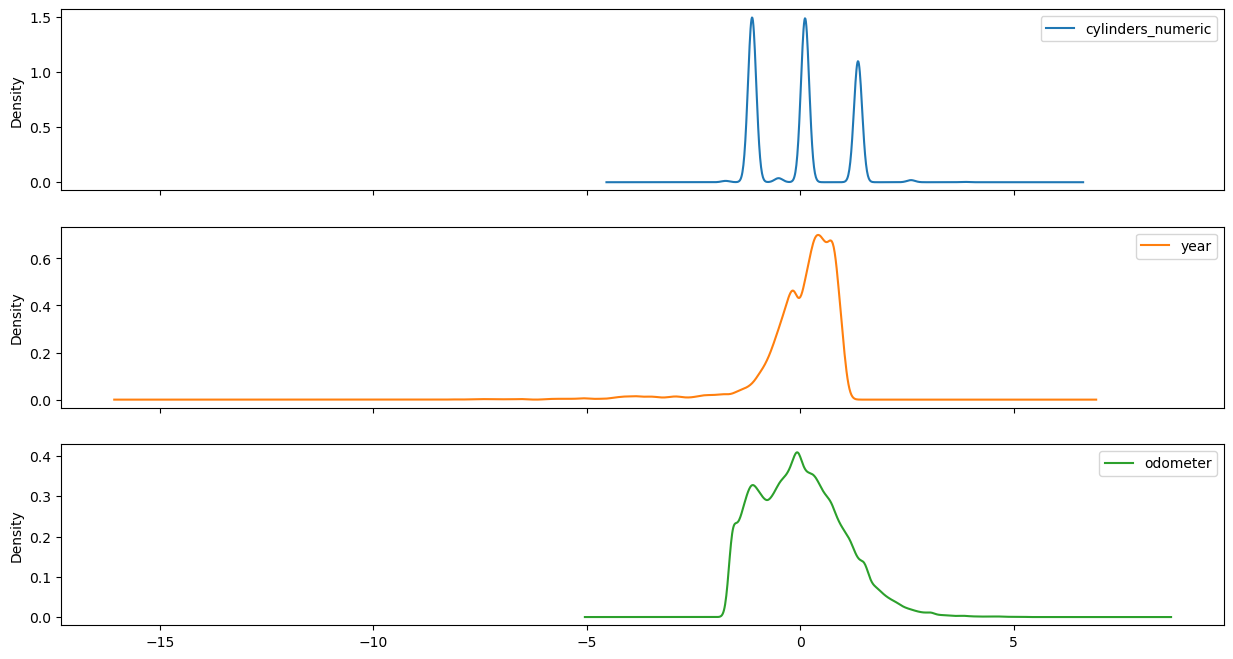

In [319]:
# initiate the Standard Scaler. this is for exploratory purposes. we will use a eventually pipeline to scale the data
# plot the kernet densities of the scaled numerical features. Pipeline will also help in imputing null values

scale = StandardScaler()

X_train_transformed = pd.DataFrame(scale.fit_transform(X_train[num_features]), \
    columns = scale.get_feature_names_out())

X_train_transformed.plot(kind = 'kde', subplots = True,figsize = (15,8));


# Data set combination

* Step 1: Numerical Only
* Step 2: Numerical + Simple Categorical (OHE)
* Step 3: Step 2 + Non Trivial - Orinal Encoding

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [ ]:
# Define the features of interest, these static values will be used in subsequent model evaluations

num_features = ['cylinders_numeric', 'year', 'odometer']

# Store the results of various models attempted in a data frame
#
models_evaluated = pd.DataFrame()

# helper function to retrieve the evaluation metrics of the model

def eval_model_linear (pipeline, regression_type, feature_type):
    
    start_time = time.time()
    
    pipeline.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    train_rmse = root_mean_squared_error(pipeline.predict(X_train), y_train)
    test_rmse = root_mean_squared_error(pipeline.predict(X_test), y_test)
    feature_names = pipeline[:-1].get_feature_names_out()
    number_of_features = len(feature_names)
    
    r2_test = pipeline.score(X_test, y_test)
    
    return ({'model': regression_type, \
            'feature_type': feature_type, \
            'number of features': number_of_features, \
            'training rmse': train_rmse, \
            'testing rmse': test_rmse, \
            'r2 test data': r2_test, 
            'best_alpha': 'n/a',
            'time to fit model (seconds):': elapsed_time})    
    

def eval_model_lasso_ridge (grid, regression_type, feature_type):
        
    start_time = time.time()

    grid.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    train_rmse = root_mean_squared_error(grid.predict(X_train), y_train)
    test_rmse = root_mean_squared_error(grid.predict(X_test), y_test)
    
    #feature_names = grid.get_feature_names_out()
    # number_of_features = len(feature_names)
    # number_of_features = 0
    
    r2_test = grid.score(X_test, y_test)
    
    #print(grid.best_estimator_)
    #print(type(grid.best_params_))
    best_alpha = {list(grid.best_params_.values())[0]}
    
    return ({'model': regression_type, \
            'feature_type': feature_type, \
            'number of features': '', \
            'training rmse': train_rmse, \
            'testing rmse': test_rmse, \
            'r2 test data': r2_test, 
            'best_alpha': best_alpha, 
            'time to fit model (seconds):': elapsed_time})   

##### Step 1. Numerical

In [321]:
# Step 1.1 Linear Regression model with numerical features only

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linreg', LinearRegression())])

dict = eval_model_linear(pipeline, 'LinearRegression', 'All Numeric')
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])])

pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer'])])),
                ('linreg', LinearRegression())])

In [322]:
# Step 1.2 Ridge Regression model with numerical features only

param_grid = {'ridge__alpha': [0.1, 1, 10, 100, 1000]}

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])
pipeline = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge())])

grid = GridSearchCV(pipeline, param_grid=param_grid)

dict= eval_model_lasso_ridge(grid, 'Ridge', 'All Numeric')
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])])

pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer'])])),
                ('ridge', Ridge())])

In [323]:
# Step 1.3 Lasso Regression model with numerical features only

param_grid = {'lasso__alpha': [0.1, 1, 10, 100, 1000]}

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])
pipeline = Pipeline([('preprocessor', preprocessor), ('lasso', Lasso())])

grid = GridSearchCV(pipeline, param_grid=param_grid)

dict = eval_model_lasso_ridge(grid, 'Lasso', 'All Numeric')
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])])

pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer'])])),
                ('lasso', Lasso())])

In [324]:
models_evaluated

,model,feature_type,number of features,training rmse,testing rmse,r2 test data,best_alpha,time to fit model (seconds):
0,LinearRegression,All Numeric,9,10587.696391,10472.645497,0.326749,n/a,0.053839
0,Ridge,All Numeric,,10587.696411,10472.640062,0.326750,{10},1.394213
0,Lasso,All Numeric,,10587.696885,10472.632076,0.326751,{1},7.931735


##### Step 2. Numerical and Categorical

In [325]:
cat_features_nominal = ['manufacturer', 'type', 'fuel']
cat_features_ordinal = ['condition', 'title_status']

# ordinal_data_categories = {
#     'title_status': ['parts only', 'missing', 'salvage', 'rebuilt', 'lien', 'clean'],
#     'condition': ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
# }

ordinal_data_categories = [
    ['salvage', 'fair', 'good', 'excellent', 'like new', 'new'],
    ['parts only', 'missing', 'salvage', 'rebuilt', 'lien', 'clean'],
]


In [326]:
# Step 2.1 Linear Regression with numerical and categorical columns


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical', categorical_transformer, cat_features)])

pipeline = Pipeline([('preprocessor', preprocessor), ('LinearRegression', LinearRegression())])

#grid = GridSearchCV(pipeline, param_grid=param_grid)

dict= eval_model_linear(pipeline, 'Linear', 'Numerical and Categorical')
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])])



pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['condition', 'title_status',
                                                   'manufacturer', 'type',
                                                   'fuel'])])),
                ('LinearRegression', LinearRegression())])

In [327]:
models_evaluated

,model,feature_type,number of features,training rmse,testing rmse,r2 test data,best_alpha,time to fit model (seconds):
0,LinearRegression,All Numeric,9,10587.696391,10472.645497,0.326749,n/a,0.053839
0,Ridge,All Numeric,,10587.696411,10472.640062,0.326750,{10},1.394213
0,Lasso,All Numeric,,10587.696885,10472.632076,0.326751,{1},7.931735
0,Linear,Numerical and Categorical,81,9713.039047,9606.833457,0.433468,n/a,1.194928


In [328]:
# Step 2.2 Ridge Regression model with numerical and categorical features

param_grid = {'ridge__alpha': [0.1, 1, 10, 100, 1000]}

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical', categorical_transformer, cat_features)])

pipeline = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge())])

grid = GridSearchCV(pipeline, param_grid=param_grid)

dict= eval_model_lasso_ridge(grid, 'Ridge', 'Numerical and Categorical')
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['condition', 'title_status',
                                                   'manufacturer', 'type',
                                                   'fuel'])])),
                ('ridge', Ridge())])

In [329]:
# Step 2.3 Lasso Regression model with numerical and categorical features

param_grid = {'lasso__alpha': [0.1, 1, 10, 100, 1000]}
cat_features = ['condition', 'title_status', 'type', 'fuel', 'manufacturer']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical', categorical_transformer, cat_features)])

pipeline = Pipeline([('preprocessor', preprocessor), ('lasso', Lasso(max_iter=10000))])

# Change the default parameters for GridSearchCV for Lasso to avoid convergence warnings - change cross validation to 2, 
# and n_jobs to -1 (to use all processors)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=2, n_jobs=-1)

dict = eval_model_lasso_ridge(grid, 'Lasso', 'Numerical and Categorical')
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])])

pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['condition', 'title_status',
                                                   'type', 'fuel',
                                                   'manufacturer'])])),
                ('lasso', Lasso(max_iter=10000))])

In [330]:
# Step 2.4 Linear Regression with numerical and categorical columns with Ordinal Encoding

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_transformer_ordinal = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('ordinal', OrdinalEncoder(categories=ordinal_data_categories))])

categorical_transformer_nominal = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical_ordinal', categorical_transformer_ordinal, cat_features_ordinal), 
                  ('categorical_nominal', categorical_transformer_nominal, cat_features_nominal)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linear', LinearRegression())])

dict = eval_model_linear(pipeline, 'LinearRegression', 'Numerical and Categorical incl Ordinal')
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer']),
                                                 ('categorical_ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalE...
                                                                                               'excellent',
                                                                                               'like '
                                                                                               'new',
                                                                                               'new'],
                                                                                              ['parts '
                                                                                               'only',
                                                                                               'missing',
                                                                                               'salvage',
                                                                                               'rebuilt',
                                                                                               'lien',
                                                                                               'clean']]))]),
                                                  ['condition',
                                                   'title_status']),
                                                 ('categorical_nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['manufacturer', 'type',
                                                   'fuel'])])),
                ('linear', LinearRegression())])

In [331]:

# print(len(pipeline.named_steps['lasso'].coef_))


# print(pipeline[:-1].get_feature_names_out())

# #print(pipeline.score)
# pipeline.named_steps['lasso'].coef_


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

This analysis models LinearRegression, Ridge and Lasso regresion models for the vehicles data set
* 3 model options for numerical columns only
* 3 model options for  numerical and categorical columns
* 1 model option that includes numerical, and categorical both nominal and ordinal values

For each run of the model we captured the training rmse, test rmse, r2 score, alpha (if applicable) and time taken to fit the model

In [332]:
models_evaluated

,model,feature_type,number of features,training rmse,testing rmse,r2 test data,best_alpha,time to fit model (seconds):
0,LinearRegression,All Numeric,9,10587.696391,10472.645497,0.326749,n/a,0.053839
0,Ridge,All Numeric,,10587.696411,10472.640062,0.326750,{10},1.394213
0,Lasso,All Numeric,,10587.696885,10472.632076,0.326751,{1},7.931735
0,Linear,Numerical and Categorical,81,9713.039047,9606.833457,0.433468,n/a,1.194928
0,Ridge,Numerical and Categorical,,9713.442483,9605.135909,0.433668,{10},11.415510
0,Lasso,Numerical and Categorical,,9713.141085,9604.837518,0.433703,{0.1},135.615784
0,LinearRegression,Numerical and Categorical incl Ordinal,71,9729.054941,9618.911317,0.432042,n/a,0.794897


We observed that the regression models on numerical columns had very low r2 scores (~32%). These were improved somewhat with the inclusion of categorical columns with OneHotEncoding, the scores went up to 43%. Both Ridge (alpha = 0.1) Lasso (alpha = 10) as provided by GridSearchCV (default CV=5) yield very similar results to LinearRegression models. 

Note: on Lasso for numerical and categorical columns. The model fit was taking a long time and providing convergence warnings, so changed the default parameters for GridSearchCV: change cross validation to 2, # and n_jobs to -1 (to use all processors)

##### Ways to improve the model

a. The original data set had a lot of missing data, ranging from 20 to 40$ for these columns
* condition       40.79
* cylinders       41.62
* drive           30.59
* type            21.75

These features were imputed using mode method. Perhaps KNeighborsClassifier may be used to find values for these categorical variables

b. Instead of computing missing values, when all missing values are dropped, the data shrinks to 15% of it's original size. This translates to 60K records. Running the above models in these data set increases the r2 values for numerical and categorical columns to 62%. It requires further investigation on spread of data in this significanly reduced data set and whether it provides a good representation of the overall data


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.